In [110]:
import numpy as np
from colour import Color
from matplotlib import colors
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import gif

#CUSTOM CMAP
def customcmap(t_i, t_r):
    s = Color("#f5ebeb")
    i1 = Color("#5e0202")
    i2 = Color("#e81717")
    r1 = Color("#e8c917")
    r2 = Color("#e8db90")
    clist = [s] + list(i1.range_to(i2, t_i - 1)) + list(r1.range_to(r2, t_r))
    clist = [c.hex for c in clist]
    
    return colors.ListedColormap(clist)


#PROPOGATOR FUNCTION
def propogator(tau_t,x_dim,y_dim,t_i,t_r,det_prob):
    print(tau_t)
    #looping through all the blocks (except the boundaries)
    t=tau_t.copy()  #use .copy() to prevent simaltaneous changes in both t and tau_t
    count=0
    for i in np.arange(1,x_dim+1):
        for j in np.arange(1,y_dim+1):
            #for susceptible individuals (Using MOORE Neighbourhood)
            if(tau_t[i][j]==0):    
                count=0
                probability=0    
                if(1<=tau_t[i-1][j]<=t_i): #any infected cell with t between 1 and t_i infects others by adding a count
                    count=count+1
                if(1<=tau_t[i][j-1]<=t_i):
                    count=count+1
                if(1<=tau_t[i+1][j]<=t_i):
                    count=count+1
                if(1<=tau_t[i][j+1]<=t_i):
                    count=count+1
                if(1<=tau_t[i-1][j-1]<=t_i):
                    count=count+1
                if(1<=tau_t[i-1][j+1]<=t_i):
                    count=count+1
                if(1<=tau_t[i+1][j+1]<=t_i):
                    count=count+1
                if(1<=tau_t[i+1][j-1]<=t_i):
                    count=count+1

                probability=count/8
                x=np.random.random()
                if(x<=probability*det_prob): #if det_prob=8, even a single infected neighbour can infect, for det_prob=1, we get the standard probabilistic model.
                    t[i][j]=1
                
            #for infected and refractory
            elif(1<=tau_t[i][j]<t_i+t_r):
                t[i][j]=t[i][j]+1
                
            #last stage (tau_0----->0)
            elif(tau_t[i][j]==t_i+t_r):
                t[i][j]=0
    #BOUNDARY CONDITIONS (just recovered after getting infected)
    t[:,0]=t_i+1
    t[0,:]=t_i+1
    t[:,x_dim+1]=t_i+1
    t[y_dim+1,:]=t_i+1
    
    return t


[[5 5 5 ... 5 5 5]
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 ...
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 [5 5 5 ... 5 5 5]]
G 1 neighbour=  1
i= 7 j= 46 count= 1
C 1 neighbour=  1
i= 7 j= 47 count= 1
H 1 neighbour=  1
i= 7 j= 48 count= 1
D 1 neighbour=  0
i= 8 j= 46 count= 1
B 1 neighbour=  1
i= 8 j= 48 count= 1
F 1 neighbour=  1
i= 9 j= 46 count= 1
A 1 neighbour=  1
i= 9 j= 47 count= 1
E 1 neighbour=  1
i= 9 j= 48 count= 1
G 1 neighbour=  1
i= 12 j= 22 count= 1
C 1 neighbour=  1
i= 12 j= 23 count= 1
H 1 neighbour=  1
i= 12 j= 24 count= 1
G 1 neighbour=  1
i= 12 j= 75 count= 1
C 1 neighbour=  1
i= 12 j= 76 count= 1
H 1 neighbour=  1
i= 12 j= 77 count= 1
D 1 neighbour=  0
i= 13 j= 22 count= 1
B 1 neighbour=  1
i= 13 j= 24 count= 1
D 1 neighbour=  0
i= 13 j= 75 count= 1
B 1 neighbour=  1
i= 13 j= 77 count= 1
F 1 neighbour=  1
i= 14 j= 22 count= 1
A 1 neighbour=  1
i= 14 j= 23 count= 1
E 1 neighbour=  1
i= 14 j= 24 count= 1
G 1 neighbour=  1
i= 14 j= 39 count= 1
C 1 neighbour=  1
i= 14 j= 40 

i= 67 j= 67 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 68 j= 63 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 68 j= 67 count= 2
F 1 neighbour=  1
i= 69 j= 63 count= 1
A 1 neighbour=  1
F 2 neighbour=  1
i= 69 j= 64 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 69 j= 65 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 69 j= 66 count= 2
E 1 neighbour=  1
i= 69 j= 67 count= 1
G 1 neighbour=  1
i= 81 j= 27 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 81 j= 28 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 81 j= 29 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 81 j= 30 count= 2
H 1 neighbour=  1
i= 81 j= 31 count= 1
D 1 neighbour=  0
G 2 neighbour=  1
i= 82 j= 27 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 82 j= 31 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 83 j= 27 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 83 j= 31 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 84 j= 27 count= 2
B 1 neighb

E 2 neighbour=  1
H 3 neighbour=  1
i= 16 j= 92 count= 3
G 1 neighbour=  1
i= 17 j= 1 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 17 j= 2 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 17 j= 3 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 17 j= 4 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 17 j= 5 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 17 j= 6 count= 2
H 1 neighbour=  1
i= 17 j= 7 count= 1
D 1 neighbour=  0
G 2 neighbour=  1
i= 17 j= 8 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 17 j= 14 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
i= 17 j= 37 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 17 j= 43 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
i= 17 j= 86 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 17 j= 92 count= 2
D 1 neighbour=  5
G 2 neighbour=  1
i= 18 j= 1 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 18 j= 7 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 18 j= 8 count= 3
B 1 ne

H 3 neighbour=  1
i= 61 j= 23 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 61 j= 24 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 61 j= 25 count= 2
H 1 neighbour=  1
i= 61 j= 26 count= 1
D 1 neighbour=  0
G 2 neighbour=  1
i= 62 j= 20 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 62 j= 26 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 63 j= 20 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 63 j= 26 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 64 j= 20 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 64 j= 26 count= 3
G 1 neighbour=  1
i= 64 j= 62 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 64 j= 63 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 64 j= 64 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 64 j= 65 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 64 j= 66 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 64 j= 67 count= 

G 2 neighbour=  1
H 3 neighbour=  1
i= 11 j= 90 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 11 j= 91 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 11 j= 92 count= 2
H 1 neighbour=  1
i= 11 j= 93 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 12 j= 19 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 12 j= 27 count= 3
D 1 neighbour=  0
G 2 neighbour=  1
i= 12 j= 36 count= 2
A 1 neighbour=  1
B 2 neighbour=  1
F 3 neighbour=  1
H 4 neighbour=  1
i= 12 j= 44 count= 4
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 12 j= 45 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 12 j= 46 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 12 j= 47 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 12 j= 48 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 12 j= 49 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 12 j= 50 count= 2
E 1 neighbour=  1
i= 12 j= 51 count= 1
D

i= 39 j= 98 count= 1
G 1 neighbour=  1
i= 53 j= 39 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 53 j= 40 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 41 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 42 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 43 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 44 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 45 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 53 j= 46 count= 2
H 1 neighbour=  1
i= 53 j= 47 count= 1
G 1 neighbour=  1
i= 53 j= 89 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 53 j= 90 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 91 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 92 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 93 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 53 j= 94 count= 3
C 1 neighbour=  

A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 17 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 18 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 19 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 97 j= 20 count= 2
E 1 neighbour=  1
i= 97 j= 21 count= 1
[[5 5 5 ... 5 5 5]
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 ...
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 [5 5 5 ... 5 5 5]]
G 1 neighbour=  1
i= 3 j= 42 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 3 j= 43 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 44 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 45 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 46 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 47 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 48 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 49 count= 3
C 1 neighbour=  1
G 2

F 2 neighbour=  1
i= 18 j= 72 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 18 j= 73 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 18 j= 74 count= 3
A 1 neighbour=  1
D 2 neighbour=  0
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
i= 18 j= 75 count= 5
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 18 j= 94 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 19 j= 16 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 19 j= 35 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 19 j= 45 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 19 j= 75 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 19 j= 94 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 20 j= 16 count= 3
F 1 neighbour=  1
i= 20 j= 35 count= 1
A 1 neighbour=  1
F 2 neighbour=  1
i= 20 j= 36 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 20 j= 37 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 2

C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 21 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 22 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 23 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 24 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 25 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 26 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 59 j= 27 count= 2
H 1 neighbour=  1
i= 59 j= 28 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 59 j= 38 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 48 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 59 j= 88 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 98 count= 3
D 1 neighbour=  0
G 2 neighbour=  1
i= 60 j= 18 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 60 j= 28 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 

A 1 neighbour=  1
F 2 neighbour=  1
i= 88 j= 25 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 26 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 27 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 28 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 29 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 30 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 31 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 32 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 88 j= 33 count= 2
E 1 neighbour=  1
i= 88 j= 34 count= 1
D 1 neighbour=  0
G 2 neighbour=  1
i= 89 j= 12 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 89 j= 22 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 90 j= 12 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 90 j= 22 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 9

i= 13 j= 83 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 13 j= 95 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
i= 14 j= 1 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 14 j= 2 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 14 j= 3 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 14 j= 4 count= 3
C 1 neighbour=  1
D 2 neighbour=  0
G 3 neighbour=  1
H 4 neighbour=  1
i= 14 j= 5 count= 4
B 1 neighbour=  1
D 2 neighbour=  1
F 3 neighbour=  1
G 4 neighbour=  1
H 5 neighbour=  1
i= 14 j= 17 count= 5
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 14 j= 29 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 14 j= 34 count= 3
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 14 j= 46 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 14 j= 47 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 14 j= 48 count= 3
A 1 neighbou

B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 34 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 35 j= 88 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 35 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 36 j= 88 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 36 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 37 j= 88 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 37 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 38 j= 88 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 38 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 39 j= 88 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 39 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 40 j= 88 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 40 j= 100 count= 2
F 1 neighbour=  1
i= 41 j= 88 count= 1
A 1 neighbour= 

A 1 neighbour=  1
F 2 neighbour=  1
i= 70 j= 18 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 19 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 20 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 21 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 22 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 23 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 24 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 25 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 26 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 27 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 70 j= 28 count= 2
E 1 neighbour=  1
i= 70 j= 29 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 70 j= 59 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 70 j= 71 count= 3
D 1 neighbour=  0
F 2 

i= 6 j= 83 count= 1
D 1 neighbour=  0
G 2 neighbour=  1
i= 7 j= 16 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 7 j= 30 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 7 j= 40 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 7 j= 54 count= 3
D 1 neighbour=  0
G 2 neighbour=  1
i= 7 j= 69 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 7 j= 83 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 8 j= 16 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 30 count= 3
G 1 neighbour=  1
i= 8 j= 33 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 8 j= 34 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 35 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 36 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 37 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 38 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 39 count

F 3 neighbour=  1
i= 26 j= 14 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 15 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 16 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 26 j= 17 count= 2
E 1 neighbour=  1
i= 26 j= 18 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 26 j= 73 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 87 count= 3
A 1 neighbour=  1
F 2 neighbour=  1
i= 27 j= 1 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 2 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 3 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 4 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 5 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 6 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 7 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 8 

H 2 neighbour=  1
i= 61 j= 72 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 61 j= 86 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 61 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 62 j= 16 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 62 j= 30 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 62 j= 36 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 62 j= 50 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 62 j= 58 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 62 j= 72 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 62 j= 86 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 62 j= 100 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 63 j= 16 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 63 j= 30 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 63 j= 36 count= 2
B 

i= 93 j= 24 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 94 j= 10 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 94 j= 24 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 95 j= 10 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 95 j= 24 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 96 j= 10 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 96 j= 24 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 97 j= 10 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 97 j= 24 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 98 j= 10 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 98 j= 24 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 99 j= 10 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 99 j= 24 count= 2
F 1 neighbour=  1
i= 100 j= 10 count= 1
A 1 neighbour=  1
F 2 neighbour=  1
i= 100 j= 11 count= 2
A 1 neighbour=  1

B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 14 j= 97 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 15 j= 31 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 15 j= 32 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 15 j= 55 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 15 j= 68 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 15 j= 97 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 16 j= 31 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 16 j= 32 count= 3
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 16 j= 48 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 16 j= 49 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 16 j= 50 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 16 j= 51 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 16 j= 52 count= 3
A 1 nei

H 3 neighbour=  1
i= 49 j= 40 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 41 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 42 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 43 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 44 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 45 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 46 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 47 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 48 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 49 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 49 j= 50 count= 2
H 1 neighbour=  1
i= 49 j= 51 count= 1
G 1 neighbour=  1
i= 49 j= 85 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 49 j= 86 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 87 count= 3
C 1 neighbour=  1
G

E 2 neighbour=  1
H 3 neighbour=  1
i= 66 j= 31 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 66 j= 57 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 66 j= 73 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 67 j= 15 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 67 j= 31 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 67 j= 57 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 67 j= 73 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 68 j= 15 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 68 j= 31 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 68 j= 57 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 68 j= 73 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 69 j= 15 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 69 j= 31 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 nei

i= 99 j= 9 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 99 j= 25 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 100 j= 9 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 100 j= 25 count= 2
[[5 5 5 ... 5 5 5]
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 ...
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 [5 5 5 ... 5 5 5]]
D 1 neighbour=  0
G 2 neighbour=  1
i= 1 j= 38 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 1 j= 56 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 2 j= 38 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 2 j= 56 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 3 j= 38 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 56 count= 3
G 1 neighbour=  1
i= 4 j= 14 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 4 j= 15 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 4 j= 16 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 4 j= 17 count= 3
C 1 neighbour=  1
G 

C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 90 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 91 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 92 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 93 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 94 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 95 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 96 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 97 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 98 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 99 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 26 j= 100 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 27 j= 20 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 27 j= 71 count= 3
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 ne

H 3 neighbour=  1
i= 58 j= 58 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 59 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 60 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 61 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 62 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 63 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 64 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 65 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 66 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 67 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 68 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 69 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 70 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 58 j

i= 74 j= 33 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 74 j= 34 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 74 j= 35 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 74 j= 36 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 74 j= 37 count= 2
H 1 neighbour=  1
i= 74 j= 38 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 74 j= 56 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 74 j= 74 count= 3
D 1 neighbour=  0
G 2 neighbour=  1
i= 75 j= 20 count= 2
B 1 neighbour=  1
H 2 neighbour=  1
i= 75 j= 38 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
i= 75 j= 56 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 75 j= 74 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 76 j= 20 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 76 j= 38 count= 3
F 1 neighbour=  1
i= 76 j= 56 count= 1
A 1 neighbour=  1
F 2 neighbour=  1
i= 76 j= 57 count= 2
A 1 neighbour=  1
E 2 neighbour=  

i= 6 j= 57 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 6 j= 66 count= 3
B 1 neighbour=  1
H 2 neighbour=  1
i= 6 j= 99 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 7 j= 13 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 7 j= 57 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 7 j= 66 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 7 j= 99 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 8 j= 13 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 57 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 8 j= 66 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 8 j= 99 count= 3
G 1 neighbour=  1
i= 9 j= 1 count= 1
C 1 neighbour=  1
G 2 neighbour=  1
i= 9 j= 2 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 9 j= 3 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 9 j= 4 count= 3
C 1 neighbour=  1
G 

F 2 neighbour=  1
G 3 neighbour=  1
i= 36 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 37 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 38 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 39 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 40 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 41 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 42 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 43 j= 84 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 44 j= 84 count= 2
F 1 neighbour=  1
i= 45 j= 84 count= 1
A 1 neighbour=  1
F 2 neighbour=  1
i= 45 j= 85 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 45 j= 86 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 45 j= 87 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 45 j= 88 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 

G 3 neighbour=  1
i= 65 j= 13 count= 3
B 1 neighbour=  1
D 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 65 j= 33 count= 6
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 65 j= 53 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 65 j= 55 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 65 j= 75 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 65 j= 83 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 66 j= 13 count= 3
B 1 neighbour=  1
D 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 66 j= 33 count= 5
B 1 neighbour=  1
E 2 neighbour=  1
i= 66 j= 53 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 66 j= 55 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 66 j= 75 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 66 j= 83 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 67 j= 13 count= 3
B 1 nei

D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 92 j= 7 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 92 j= 39 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 93 j= 7 count= 3
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 93 j= 27 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 28 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 29 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 30 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 31 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 32 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 33 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 34 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 35 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 36 count= 3
A 1 neigh

E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 40 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 41 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 42 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 43 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 44 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 45 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 46 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 47 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 48 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 26 j= 49 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 26 j= 50 count= 2
E 1 neighbour=  1
i= 26 j= 51 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 26 j= 69 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 27 j= 22 count= 3
D 1 neighbour=  0
F 2 

C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 56 j= 71 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 56 j= 72 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 56 j= 73 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 56 j= 74 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 56 j= 75 count= 2
H 1 neighbour=  1
i= 56 j= 76 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 56 j= 82 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 57 j= 12 count= 3
B 1 neighbour=  1
D 2 neighbour=  1
E 3 neighbour=  1
G 4 neighbour=  1
H 5 neighbour=  1
i= 57 j= 54 count= 5
B 1 neighbour=  1
H 2 neighbour=  1
i= 57 j= 76 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 57 j= 82 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 58 j= 12 count= 3
B 1 neighbour=  1
D 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 58 j= 54 count= 6
B 1 nei

F 2 neighbour=  1
G 3 neighbour=  1
i= 86 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 86 j= 40 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 87 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 87 j= 40 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 88 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 88 j= 40 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 89 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 89 j= 40 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 90 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 90 j= 40 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 91 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 91 j= 40 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 92 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=

D 2 neighbour=  0
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
i= 25 j= 68 count= 5
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 23 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
i= 26 j= 28 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
i= 26 j= 52 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 26 j= 68 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 27 j= 23 count= 3
F 1 neighbour=  1
i= 27 j= 28 count= 1
A 1 neighbour=  1
F 2 neighbour=  1
i= 27 j= 29 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 30 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 31 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 32 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 33 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 34 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 27 j= 35 count= 3
A 1 neighbour=  1
E 2 

i= 55 j= 81 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 56 j= 11 count= 3
B 1 neighbour=  1
H 2 neighbour=  1
i= 56 j= 77 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 56 j= 81 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 57 j= 11 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 57 j= 77 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 57 j= 81 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 58 j= 11 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 58 j= 77 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 58 j= 81 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 59 j= 11 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 59 j= 77 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 59 j= 81 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 60 j= 11 count= 3
B 1 neighbour=  1
E 2 

B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 91 j= 41 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 92 j= 5 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 92 j= 41 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 93 j= 5 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 93 j= 41 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 94 j= 5 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 94 j= 41 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 95 j= 5 count= 3
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 95 j= 29 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 95 j= 30 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 95 j= 31 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 95 j= 32 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 95 j= 33 count= 3
A 1 neighbo

E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 72 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 73 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 74 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 75 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 76 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 77 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 78 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 79 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 80 count= 3
A 1 neighbour=  1
D 2 neighbour=  0
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
i= 35 j= 81 count= 5
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 36 j= 81 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 37 j= 81 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 38 j= 81 count= 3
D 1 nei

H 6 neighbour=  1
i= 70 j= 40 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 70 j= 41 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
H 4 neighbour=  1
i= 70 j= 42 count= 4
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 43 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 44 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 45 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 46 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 47 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 48 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 49 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 50 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 70 j= 51 count= 3
A 1 neighbour=  1
D 2 neighbour=  0
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighb

i= 1 j= 99 count= 3
C 1 neighbour=  1
H 2 neighbour=  1
i= 1 j= 100 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 2 j= 9 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 2 j= 61 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 2 j= 62 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 3 j= 9 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 3 j= 61 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 3 j= 62 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 4 j= 9 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 4 j= 61 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 4 j= 62 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
i= 5 j= 1 count= 2
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 5 j= 2 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 5 j= 3 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 5 

C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 31 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 32 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 33 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 34 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 35 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 36 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 37 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 38 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 39 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 40 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 41 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 42 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 43 j= 43 count= 3
C 1 neighbour=  1
G 2 nei

E 2 neighbour=  1
F 3 neighbour=  1
i= 71 j= 95 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 71 j= 96 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 71 j= 97 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 71 j= 98 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 71 j= 99 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 71 j= 100 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 72 j= 9 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 72 j= 43 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 72 j= 51 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 72 j= 79 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 73 j= 9 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 73 j= 43 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 73 j= 51 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 73 j=

A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 23 j= 55 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 23 j= 56 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 23 j= 57 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 23 j= 58 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 23 j= 59 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 23 j= 60 count= 3
A 1 neighbour=  1
D 2 neighbour=  0
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
i= 23 j= 61 count= 5
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 24 j= 55 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 24 j= 61 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 25 j= 55 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 25 j= 61 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 26 j= 55 count= 3
D 1 neighbour=  0
F 2 neighb

G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 23 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 24 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 25 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 26 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 27 count= 3
C 1 neighbour=  1
D 2 neighbour=  0
F 3 neighbour=  1
G 4 neighbour=  1
H 5 neighbour=  1
i= 49 j= 28 count= 5
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 49 j= 58 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 49 j= 78 count= 3
D 1 neighbour=  0
G 2 neighbour=  1
i= 50 j= 8 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 50 j= 58 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 50 j= 78 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 51 j= 8 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 51 j= 58 count= 3
D 1 neighbour=  0
F 2 neigh

i= 82 j= 73 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 82 j= 74 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 82 j= 75 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 82 j= 76 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 82 j= 77 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 82 j= 78 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 82 j= 79 count= 2
E 1 neighbour=  1
i= 82 j= 80 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 83 j= 2 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 83 j= 44 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 84 j= 2 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 84 j= 44 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 85 j= 2 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 85 j= 44 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 86 j

i= 41 j= 39 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 40 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 41 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 42 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 43 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 44 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 45 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 46 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 47 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 48 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 49 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 50 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 51 count= 3
C 1 neighbour=  1
G 2 neighbour=  1
H 3 neighbour=  1
i= 41 j= 52 count= 3
C 1 

F 2 neighbour=  1
G 3 neighbour=  1
i= 83 j= 1 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 83 j= 45 count= 3
F 1 neighbour=  1
i= 83 j= 49 count= 1
A 1 neighbour=  1
F 2 neighbour=  1
i= 83 j= 50 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 51 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 52 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 53 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 54 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 55 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 56 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 57 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 58 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 59 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 83 j= 60 count= 3
A 1 neighbour=  1
E 2 n

F 3 neighbour=  1
i= 36 j= 23 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 36 j= 24 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 36 j= 25 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 36 j= 26 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 36 j= 27 count= 2
E 1 neighbour=  1
i= 36 j= 28 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 36 j= 63 count= 3
A 1 neighbour=  1
F 2 neighbour=  1
i= 37 j= 1 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 2 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 3 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 4 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 5 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 6 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 7 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 8 

E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 89 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 90 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 91 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 92 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 93 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 94 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 95 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 96 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 97 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 98 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 74 j= 99 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 74 j= 100 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 75 j= 6 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 75 j

i= 37 j= 23 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 24 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 25 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 26 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 37 j= 27 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 37 j= 28 count= 2
E 1 neighbour=  1
i= 37 j= 29 count= 1
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 37 j= 62 count= 3
A 1 neighbour=  1
F 2 neighbour=  1
i= 38 j= 1 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 38 j= 2 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 38 j= 3 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 38 j= 4 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 38 j= 5 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 38 j= 6 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 38 j= 7 count= 3
A 1 neig

i= 82 j= 83 count= 3
B 1 neighbour=  1
D 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 83 j= 47 count= 6
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 83 j= 83 count= 3
B 1 neighbour=  1
D 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 84 j= 47 count= 5
B 1 neighbour=  1
E 2 neighbour=  1
i= 84 j= 83 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
H 4 neighbour=  1
i= 85 j= 47 count= 4
A 1 neighbour=  1
F 2 neighbour=  1
i= 85 j= 48 count= 2
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 49 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 50 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 51 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 52 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 53 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 54 count= 3
A 1 nei

E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 11 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 12 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 13 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 14 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 15 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 16 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 17 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 18 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 19 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 20 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 39 j= 21 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 39 j= 22 count= 2
E 1 neighbour=  1
i= 39 j= 23 count= 1
D 1 neighbour=  0
G 2 neighbour=  1
i= 39 j= 24 count= 2
D 1 neighbour=  0
F 2 neighbour=  1
G 3 

B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 95 j= 48 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 96 j= 48 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 97 j= 48 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 98 j= 48 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 99 j= 48 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 100 j= 48 count= 2
[[5 5 5 ... 5 5 5]
 [5 2 2 ... 6 6 5]
 [5 3 3 ... 7 7 5]
 ...
 [5 4 5 ... 0 0 5]
 [5 4 5 ... 0 0 5]
 [5 5 5 ... 5 5 5]]
A 1 neighbour=  1
B 2 neighbour=  1
D 3 neighbour=  1
E 4 neighbour=  1
F 5 neighbour=  1
G 6 neighbour=  1
H 7 neighbour=  1
i= 33 j= 60 count= 7
B 1 neighbour=  1
D 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
i= 34 j= 60 count= 5
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 35 j= 31 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 35 j= 32 count= 3
A 1

D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 54 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 55 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 56 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 57 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 58 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 59 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 60 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 61 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 62 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 63 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 64 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 65 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 3 neighbour=  1
i= 66 j= 3 count= 3
D 1 neighbour=  0
F 2 neighbour=  1
G 

E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 36 j= 52 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 36 j= 53 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 36 j= 54 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 36 j= 55 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 36 j= 56 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 36 j= 57 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
G 5 neighbour=  1
H 6 neighbour=  1
i= 36 j= 58 count= 6
A 1 neighbour=  1
C 2 neighbour=  1
D 3 neighbour=  0
E 4 neighbour=  1
F 5 neighbour=  1
G 6 neighbour=  1
H 7 neighbour=  1
i= 36 j

F 3 neighbour=  1
i= 88 j= 56 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 57 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 58 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 59 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 60 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 61 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 62 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 63 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 64 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 65 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 66 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 67 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j= 68 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 88 j

i= 79 j= 100 count= 2
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 80 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 81 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 82 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 83 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 84 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 85 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 86 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 87 j= 87 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 88 j= 87 count= 2
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 89 j= 51 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 89 j= 52 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 89 j= 53 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 89 

B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 92 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 93 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 94 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 95 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 96 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 97 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 98 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 99 j= 52 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 100 j= 52 count= 2
[[ 5  5  5 ...  5  5  5]
 [ 5  6  6 ... 10 10  5]
 [ 5  7  7 ... 11 11  5]
 ...
 [ 5  8  9 ...  0  0  5]
 [ 5  8  9 ...  0  0  5]
 [ 5  5  5 ...  5  5  5]]
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 81 j= 89 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 81 j= 90 count= 3


i= 84 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 85 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 86 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 87 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 88 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 89 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 90 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 91 j= 91 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 92 j= 91 count= 2
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 93 j= 55 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 56 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 57 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j= 58 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 93 j

B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 98 j= 56 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
H 3 neighbour=  1
i= 99 j= 56 count= 3
B 1 neighbour=  1
E 2 neighbour=  1
i= 100 j= 56 count= 2
[[ 5  5  5 ...  5  5  5]
 [ 5 10 10 ...  0  0  5]
 [ 5 11 11 ...  0  0  5]
 ...
 [ 5  0  0 ...  0  0  5]
 [ 5  0  0 ...  0  0  5]
 [ 5  5  5 ...  5  5  5]]
A 1 neighbour=  1
B 2 neighbour=  1
E 3 neighbour=  1
F 4 neighbour=  1
H 5 neighbour=  1
i= 85 j= 93 count= 5
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 94 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 95 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 96 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 97 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 98 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 85 j= 99 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
i= 85 j= 100 count= 2
B 1 neighbour=  1

i= 97 j= 71 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 72 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 73 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 74 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 75 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 76 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 77 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 78 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 79 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 80 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 81 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 82 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 83 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 97 j= 84 count= 3
A 1 

i= 100 j= 76 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 77 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 78 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 79 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 80 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 81 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 82 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 83 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 84 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 85 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 86 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 87 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 88 count= 3
A 1 neighbour=  1
E 2 neighbour=  1
F 3 neighbour=  1
i= 100 j= 89

[[5 5 5 ... 5 5 5]
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 ...
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 [5 5 5 ... 5 5 5]]
[[5 5 5 ... 5 5 5]
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 ...
 [5 0 0 ... 0 0 5]
 [5 0 0 ... 0 0 5]
 [5 5 5 ... 5 5 5]]


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


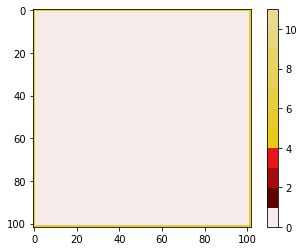

In [119]:
#MAIN PROGRAM
#parameters
det_prob=8 #Deterministic(1) or Probablistic(0) Automata
t_i=4                        # 1<=t<=t_i is the infected range
t_r=7                        # t_i+1<=t<=t_i+t_r is the refractory range
x_dim=100
y_dim=100
time=80
cmap = customcmap(t_i, t_r)

#------INITIAL CONDITIONS-----------------#
#Distribution of Initial Population

p=0.001  #initial percentage of infected individuals 
tau_list=np.zeros(((x_dim + 2)*(y_dim + 2)), dtype=int)     
for k in range ((x_dim + 2)*(y_dim + 2)):
    rand=np.random.random()
    if(0<=rand<p):
        tau_list[k]=tau_list[k]+1
    elif(p<=rand<=1):
        tau_list[k]=tau_list[k]+0
    
tau=np.reshape(tau_list,(x_dim+2,y_dim+2))
#BOUNDARY CONDITIONS (just recovered after getting infected)
tau[:,0]=t_i+1
tau[0,:]=t_i+1
tau[:,x_dim+1]=t_i+1
tau[y_dim+1,:]=t_i+1

#-------------------------------------------#
fig=plt.figure()
state=tau.copy()
plt.colorbar(plt.imshow(state, cmap=cmap, interpolation = 'nearest', vmin = 0, vmax = t_i+t_r))
ims=[] 
im=plt.imshow(state, animated=True, cmap = cmap, vmin = 0, vmax = t_i+t_r)
ims.append([im])
for t in range(time):
    state_new=propogator(state,x_dim,y_dim,t_i,t_r,det_prob)
    state=state_new.copy()
    if(t%1==0):
        im=plt.imshow(state, animated=True, cmap = cmap, vmin = 0, vmax = t_i+t_r)
        ims.append([im])

ani=animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
ani.save('SIRSmodel_det.gif', writer='imagemagick', fps=7)
plt.show()
#check for changes on github


In [107]:
1<=5<=t_i

False